In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import random

warnings.filterwarnings("ignore")
seed = 101
random.seed(seed)
np.random.seed(seed)

In [2]:
sales = pd.read_csv('sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('sell_prices.csv')
prices.name = 'prices'
calendar.replace(np.nan, 'No_event', inplace=True)

In [3]:
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [4]:
categorical_columns = sales.select_dtypes(include=['object']).columns.tolist()
sales[categorical_columns] = sales[categorical_columns].astype('category')
stores = sales.store_id.cat.codes.unique().tolist()

In [5]:
prices.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [6]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [9]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()

In [10]:
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60034810 entries, 0 to 60034809
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            category      
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   store_id      category      
 5   state_id      category      
 6   d             object        
 7   sold          int16         
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       category      
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  category      
 15  event_type_1  category      
 16  event_name_2  category      
 17  event_type_2  category      
 18  snap_CA       int8          
 19  snap_TX       int8          
 20  snap_WI       int8          
 21  sell_price    float16       
dtypes: category(11), datetime64[ns](1), float16(1), int16(3), int8(5

In [12]:
import gc
from tqdm import tqdm

dept_state_means = df.groupby(['store_id', 'dept_id'])['sell_price'].mean().reset_index()

mean_dict = {}
for index, row in dept_state_means.iterrows():
    state_dept_key = (row['store_id'], row['dept_id'])
    mean_dict[state_dept_key] = row['sell_price']

del dept_state_means
gc.collect()

def fill_missing_values(row):
    if pd.isnull(row['sell_price']):
        state_dept_key = (row['store_id'], row['dept_id'])
        return mean_dict[state_dept_key]
    else:
        return row['sell_price']

chunk_size = 400000

for i in tqdm(range(0, len(df), chunk_size)):
    chunk = df.iloc[i:i+chunk_size]
    chunk['sell_price'] = chunk.apply(fill_missing_values, axis=1)

    df.iloc[i:i+chunk_size] = chunk

    del chunk
    gc.collect()

100%|████████████████████████████████████████████████████████████████████████████████| 151/151 [17:53<00:00,  7.11s/it]


In [13]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,0,0,6.226562
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,0,0,6.226562
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,0,0,6.226562
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,0,0,6.226562
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,No_event,No_event,No_event,No_event,0,0,0,6.226562


In [15]:
df.isnull().sum()

id              0
item_id         0
dept_id         0
cat_id          0
store_id        0
state_id        0
d               0
sold            0
date            0
wm_yr_wk        0
weekday         0
wday            0
month           0
year            0
event_name_1    0
event_type_1    0
event_name_2    0
event_type_2    0
snap_CA         0
snap_TX         0
snap_WI         0
sell_price      0
dtype: int64

In [16]:
d_id = dict(zip(df.id.cat.codes, df.id))
d_item_id = dict(zip(df.item_id.cat.codes, df.item_id))
d_dept_id = dict(zip(df.dept_id.cat.codes, df.dept_id))
d_cat_id = dict(zip(df.cat_id.cat.codes, df.cat_id))
d_store_id = dict(zip(df.store_id.cat.codes, df.store_id))
d_state_id = dict(zip(df.state_id.cat.codes, df.state_id))

df.d = df['d'].apply(lambda x: x.split('_')[1]).astype(np.int16)
cols = df.dtypes.index.tolist()
types = df.dtypes.values.tolist()
for i,type in enumerate(types):
    if type.name == 'category':
        df[cols[i]] = df[cols[i]].cat.codes

df.drop('date',axis=1,inplace=True)

In [17]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1',
       'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price'],
      dtype='object')

In [18]:
lags = [1, 6, 7, 8, 14, 21, 28, 35]
for lag in tqdm(lags):
    df['sold_lag_'+str(lag)] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],as_index=False)['sold'].shift(lag).astype(np.float16)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:25<00:00, 10.68s/it]


In [19]:
df['iteam_sold_avg'] = df.groupby('item_id')['sold'].transform('mean').astype(np.float16)
df['state_sold_avg'] = df.groupby('state_id')['sold'].transform('mean').astype(np.float16)
df['store_sold_avg'] = df.groupby('store_id')['sold'].transform('mean').astype(np.float16)
df['cat_sold_avg'] = df.groupby('cat_id')['sold'].transform('mean').astype(np.float16)
df['dept_sold_avg'] = df.groupby('dept_id')['sold'].transform('mean').astype(np.float16)
df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)
df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['sold'].transform('mean').astype(np.float16)
df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['sold'].transform('mean').astype(np.float16)
df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['sold'].transform('mean').astype(np.float16)

In [21]:
df['rolling_sold_mean'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

In [85]:
# df['rolling_sold_mean2'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=15).mean()).astype(np.float16)

In [86]:
# df['rolling_sold_mean3'] = df.groupby(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])['sold'].transform(lambda x: x.rolling(window=30).mean()).astype(np.float16)

In [26]:
# df.to_csv('dataframe.csv',index=False)

In [75]:
# df['is_weekend'] = df['wday'].isin([1, 2]).astype(int)
# df['is_holiday'] = df['event_type_1'].isin(['National', 'Religious', 'Cultural']).astype(int)

In [76]:
# f=lambda x: 1 if x==2 or x==3 or x==4 or x==5 else 0
# df['is_high_sale_months']=df['month'].map(f) 

# f=lambda x: 1 if x==7 or x==1 or x==2 else 0
# df['is_high_sale_day']=df['wday'].map(f) 

# f=lambda x: 1 if x=='Christmas' else 0
# df['is_christmas']=df['event_name_1'].map(f)

In [65]:
valid = df[(df['d']>=1914) & (df['d']<1942)][['id','d','sold']]
test = df[df['d']>=1942][['id','d','sold']]
eval_preds = test['sold']
valid_preds = valid['sold']

In [ ]:
import catboost as cb
import joblib
import gc

cb_params = {
    'iterations': 1000,
    'learning_rate': 0.15,
    'depth': 8,
    'l2_leaf_reg': 350,
    'eval_metric': 'RMSE',
}

for store in stores:
    df_temp = df[df['store_id'] == store]
    model_filename = 'catboost_model' + str(d_store_id[store]) + '.pkl'

    X_train, y_train = df_temp[df_temp['d'] < 1914].drop('sold', axis=1), df_temp[df_temp['d'] < 1914]['sold']
    X_valid, y_valid = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)].drop('sold', axis=1), df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)]['sold']
    
    X_test = df_temp[df_temp['d'] >= 1942].drop('sold', axis=1)
    valid_preds = pd.Series(index=X_valid.index)

    print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
    model = cb.CatBoostRegressor(**cb_params, task_type='GPU', devices='0:1')
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=20, verbose=20)

    valid_preds = valid_preds.append(pd.Series(model.predict(X_valid), index=X_valid.index))
    eval_preds[X_test.index] = model.predict(X_test)

    joblib.dump(model, model_filename)

    del model, X_train, y_train, X_valid, y_valid, X_test, df_temp
    gc.collect()


In [34]:
# arima_order = (1, 1, 1)  # Example order (p, d, q)

In [92]:
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# import joblib

# # Define ARIMA parameters
# p, d, q = 1, 1, 1

# for store in stores:
#     df_temp = df[df['store_id'] == store]
#     model_filename = 'arima_model' + str(d_store_id[store]) + '.pkl'

#     train_data = df_temp[df_temp['d'] >= (1914 - 500)]['sold'].values

#     model = ARIMA(train_data, order=(p, d, q))
#     model_fit = model.fit()

#     valid_preds = model_fit.get_forecast(steps=28).predicted_mean

#     validation_data = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)]['sold'].values[-28:]

#     rmse = np.sqrt(mean_squared_error(validation_data, valid_preds))

#     print(f'Root Mean Squared Error (RMSE) for store {store}: {rmse}')

#     validation_index = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)].index[-28:]  # Take the last 28 days

#     # Plot the original, validation, and predicted data
#     plt.figure(figsize=(12, 6))
#     plt.plot(validation_index, validation_data, label='Validation Data', marker='o')
#     plt.plot(validation_index, valid_preds, label='ARIMA Predictions', marker='o')

#     plt.title('ARIMA Forecasting for Store: {}'.format(d_store_id[store]))
#     plt.xlabel('Day')
#     plt.ylabel('Sold')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     joblib.dump(model_fit, model_filename)

#     del model_fit, df_temp
#     gc.collect()


In [46]:
# df.rename(columns={'weekday': 'day'}, inplace=True)
# df['ds'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')


In [93]:
from prophet import Prophet

model = Prophet()

for store in stores:
    df_temp = df[df['store_id'] == store]
    model_filename = 'prophet_model' + str(d_store_id[store]) + '.pkl'
    prophet_data = df_temp[(df_temp['d'] >= (1914 - 500)) & (df_temp['d'] < 1942)][['ds', 'sold']]
    prophet_data.dropna(subset=['ds', 'sold'], inplace=True)
    prophet_data.rename(columns={'ds': 'ds', 'sold': 'y'}, inplace=True)

    model.fit(prophet_data)
    future = model.make_future_dataframe(periods=28)
    forecast = model.predict(future)

    valid_preds = forecast['yhat'][-28:]
    validation_data = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)]['sold'].values[-28:]

    rmse = np.sqrt(mean_squared_error(validation_data, valid_preds))
    print(f'Root Mean Squared Error (RMSE) for store {store}: {rmse}')

    validation_index = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)].index[-28:]

    plt.figure(figsize=(12, 6))
    plt.plot(validation_index, validation_data, label='Validation Data', marker='o')
    plt.plot(validation_index, valid_preds, label='Prophet Predictions', marker='o')

    plt.title('Prophet Forecasting for Store: {}'.format(d_store_id[store]))
    plt.xlabel('Day')
    plt.ylabel('Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

    joblib.dump(model, model_filename)

    del model, df_temp
    gc.collect()


In [94]:
# from prophet import Prophet
# import pandas as pd
# import numpy as np

# # Define Prophet model
# model = Prophet()

# for store in stores:
#     df_temp = df[df['store_id'] == store]
#     model_filename = 'prophet_model' + str(d_store_id[store]) + '.pkl'

#     # Prepare the DataFrame for Prophet
#     prophet_data = df_temp[(df_temp['d'] >= (1914 - 500)) & (df_temp['d'] < 1942)][['ds', 'sold', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price']
# ]

#     # Check for missing values and drop rows with NaN values
#     prophet_data.dropna(subset=['ds', 'sold'], inplace=True)

#     # Rename columns
#     prophet_data.rename(columns={'ds': 'ds', 'sold': 'y'}, inplace=True)

#     # Fit the Prophet model
#     model.fit(prophet_data)

#     # Create a dataframe with future dates for forecasting
#     future = model.make_future_dataframe(periods=28)  # Forecast for the next 28 days

#     # Forecast using the Prophet model
#     forecast = model.predict(future)

#     # Extract the last 28 days' forecast
#     valid_preds = forecast['yhat'][-28:]

#     # Define the validation data for the overlapping period
#     validation_data = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)]['sold'].values[-28:]

#     # Calculate RMSE only for the overlapping period
#     rmse = np.sqrt(mean_squared_error(validation_data, valid_preds))

#     # Print RMSE
#     print(f'Root Mean Squared Error (RMSE) for store {store}: {rmse}')

#     # Create an index for the validation data
#     validation_index = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)].index[-28:]  # Take the last 28 days

#     # Plot the original, validation, and predicted data
#     plt.figure(figsize=(12, 6))
#     plt.plot(validation_index, validation_data, label='Validation Data', marker='o')
#     plt.plot(validation_index, valid_preds, label='Prophet Predictions', marker='o')

#     plt.title('Prophet Forecasting for Store: {}'.format(d_store_id[store]))
#     plt.xlabel('Day')
#     plt.ylabel('Sold')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     joblib.dump(model, model_filename)

#     del model, df_temp
#     gc.collect()


In [95]:
# from prophet import Prophet
# import pandas as pd
# import numpy as np

# # Define Prophet model
# model = Prophet()

# for store in stores:
#     df_temp = df[df['store_id'] == store]
#     model_filename = 'prophet_model' + str(d_store_id[store]) + '.pkl'

#     # Prepare the DataFrame for Prophet
#     prophet_data = df_temp[(df_temp['d'] >= (1914-700)) & (df_temp['d'] < 1942)][['ds', 'sold', 'snap_CA', 'snap_TX', 'snap_WI']]

#     # Check for missing values and drop rows with NaN values
#     prophet_data.dropna(subset=['ds', 'sold'], inplace=True)  # Ensure 'y' is used

#     # Rename columns
#     prophet_data.rename(columns={'ds': 'ds', 'sold': 'y'}, inplace=True)

#     # Fit the Prophet model
#     model.fit(prophet_data)

#     # Create a dataframe with future dates for forecasting
#     future = model.make_future_dataframe(periods=28)  # Forecast for the next 28 days

#     # Forecast using the Prophet model
#     forecast = model.predict(future)

#     # Inspect the forecast components (trend, seasonality, holidays)
#     fig = model.plot_components(forecast)
#     plt.show()

#     # Extract the last 28 days' forecast
#     valid_preds = forecast['yhat'][-28:]

#     # Define the validation data for the overlapping period
#     validation_data = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)]['sold'].values[-28:]

#     # Calculate RMSE only for the overlapping period
#     rmse = np.sqrt(mean_squared_error(validation_data, valid_preds))

#     # Print RMSE
#     print(f'Root Mean Squared Error (RMSE) for store {store}: {rmse}')

#     # Create an index for the validation data
#     validation_index = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)].index[-28:]  # Take the last 28 days

#     # Plot the original, validation, and predicted data
#     plt.figure(figsize=(12, 6))
#     plt.plot(validation_index, validation_data, label='Validation Data', marker='o')
#     plt.plot(validation_index, valid_preds, label='Prophet Predictions', marker='o')

#     plt.title('Prophet Forecasting for Store: {}'.format(d_store_id[store]))
#     plt.xlabel('Day')
#     plt.ylabel('Sold')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     joblib.dump(model, model_filename)

#     del model, df_temp
#     gc.collect()


Root Mean Squared Error (RMSE) for store 0: 2.9983589514094624


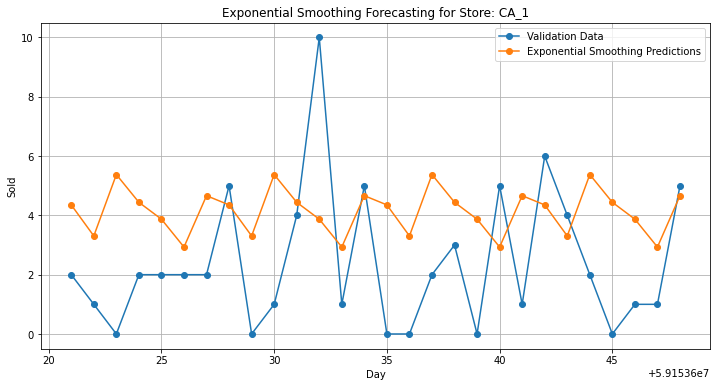

Root Mean Squared Error (RMSE) for store 1: 3.320984246005652


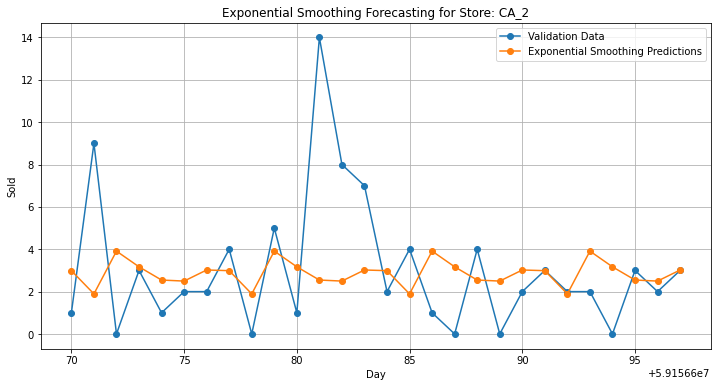

Root Mean Squared Error (RMSE) for store 2: 7.973602218655877


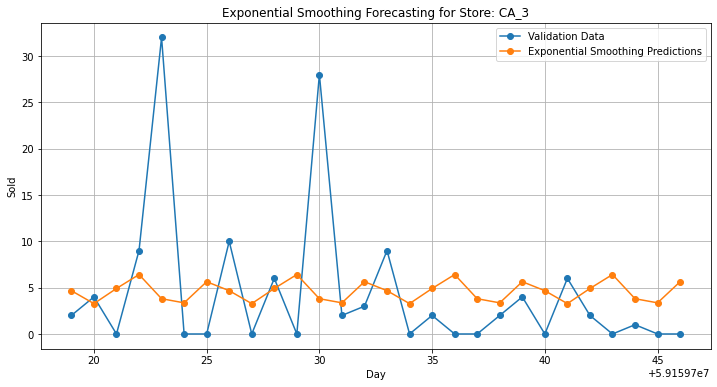

Root Mean Squared Error (RMSE) for store 3: 2.5471621846939687


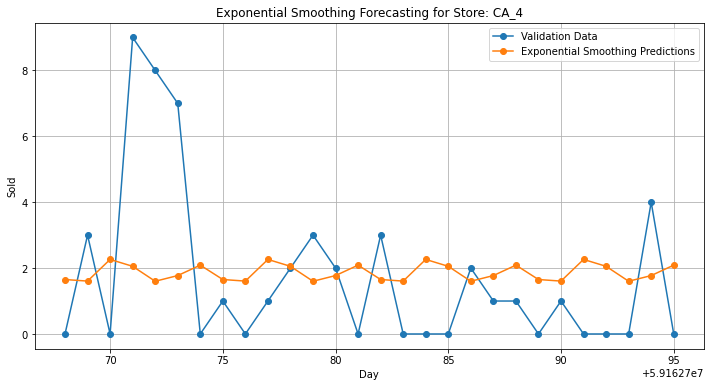

Root Mean Squared Error (RMSE) for store 4: 4.617584900618898


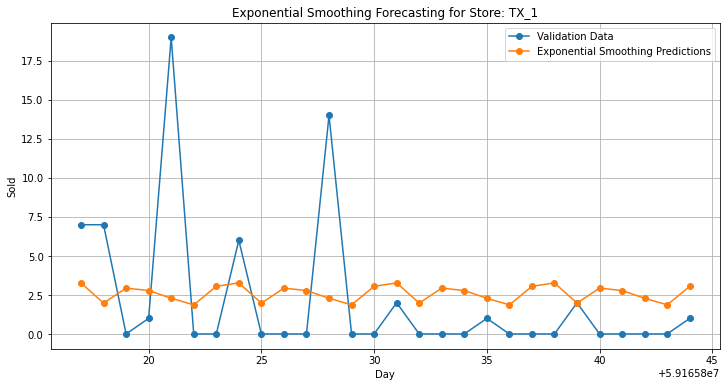

Root Mean Squared Error (RMSE) for store 5: 14.570838008181068


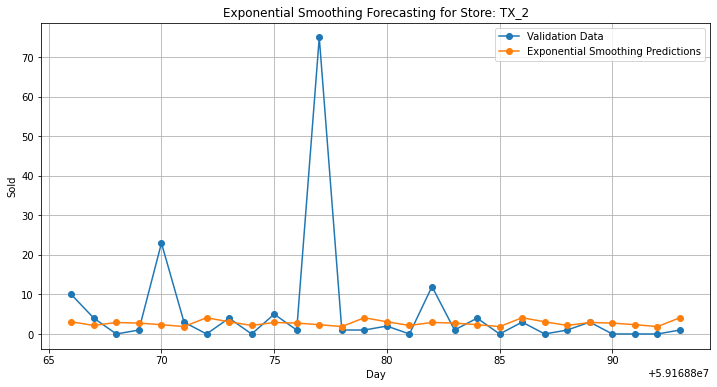

Root Mean Squared Error (RMSE) for store 6: 8.119769611003694


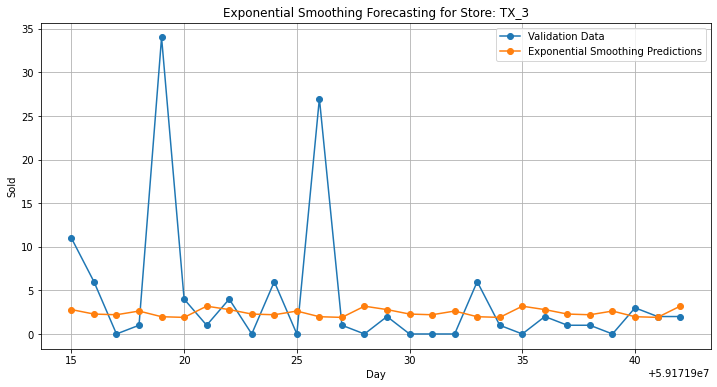

Root Mean Squared Error (RMSE) for store 7: 3.8284121082659275


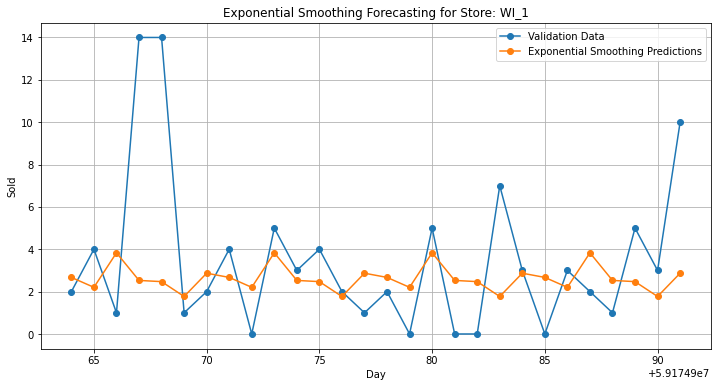

Root Mean Squared Error (RMSE) for store 8: 13.982843411083545


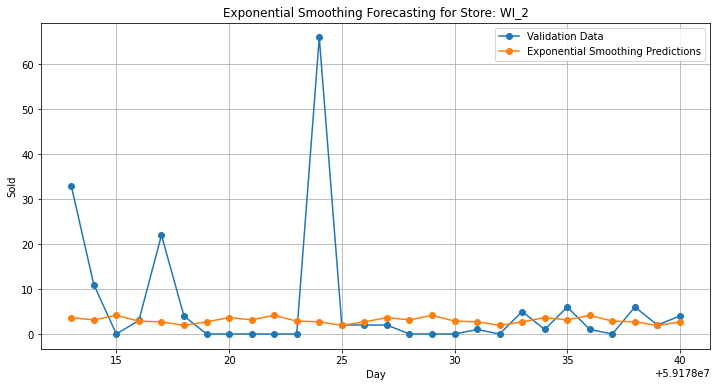

Root Mean Squared Error (RMSE) for store 9: 6.456454592536262


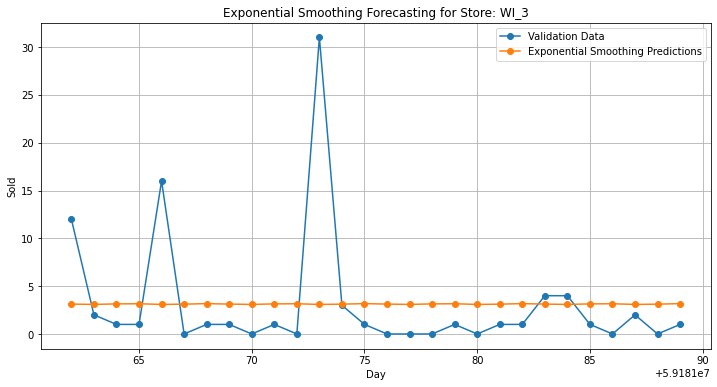

In [77]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

for store in stores:
    df_temp = df[df['store_id'] == store]
    model_filename = 'exponential_smoothing_model' + str(d_store_id[store]) + '.pkl'

    selected_features = ['sold', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'sold_lag_1', 'sold_lag_6', 'sold_lag_7',
       'sold_lag_8', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28',
       'sold_lag_35']
    smoothing_data = df_temp[(df_temp['d'] >= (1914)) & (df_temp['d'] < 1942)][selected_features]

    smoothing_data.dropna(subset=['sold'], inplace=True) 

    train_data = smoothing_data.iloc[:-28]
    valid_data = smoothing_data.iloc[-28:]

    model = ExponentialSmoothing(train_data['sold'], seasonal='add', seasonal_periods=7)  
    model_fit = model.fit()

    valid_preds = model_fit.forecast(steps=28)
    rmse = np.sqrt(mean_squared_error(valid_data['sold'], valid_preds))

    print(f'Root Mean Squared Error (RMSE) for store {store}: {rmse}')

    plt.figure(figsize=(12, 6))
    plt.plot(valid_data.index, valid_data['sold'], label='Validation Data', marker='o')
    plt.plot(valid_data.index, valid_preds, label='Exponential Smoothing Predictions', marker='o')

    plt.title('Exponential Smoothing Forecasting for Store: {}'.format(d_store_id[store]))
    plt.xlabel('Day')
    plt.ylabel('Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

    joblib.dump(model_fit, model_filename)

    del model_fit, df_temp
    gc.collect()


Root Mean Squared Error (RMSE) for store 0: 2.8322317092729183


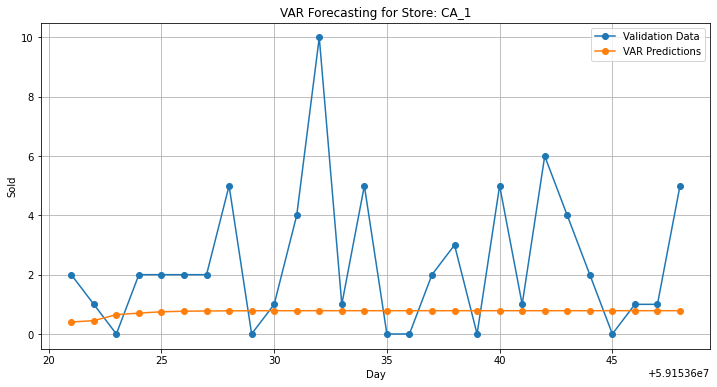

Root Mean Squared Error (RMSE) for store 1: 3.8966344702986717


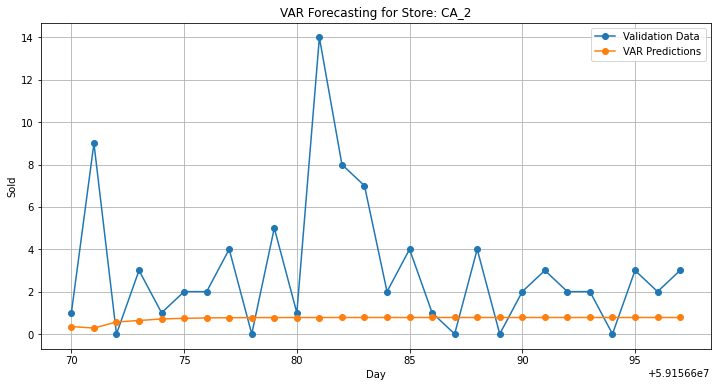

Root Mean Squared Error (RMSE) for store 2: 8.41918268590476


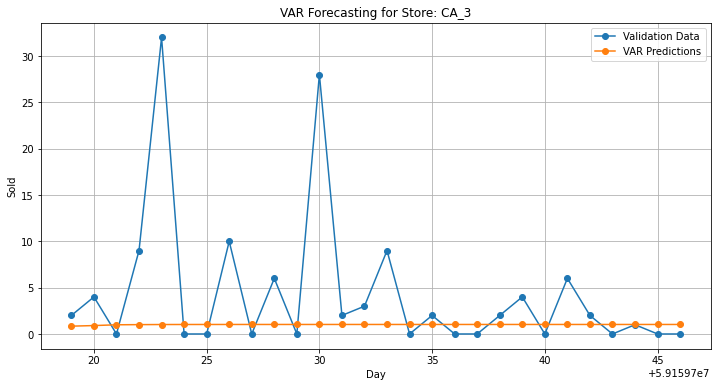

Root Mean Squared Error (RMSE) for store 3: 2.7849217598821885


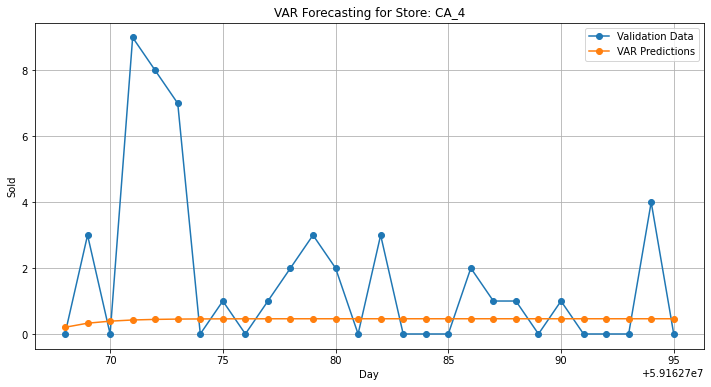

Root Mean Squared Error (RMSE) for store 4: 4.797523278520563


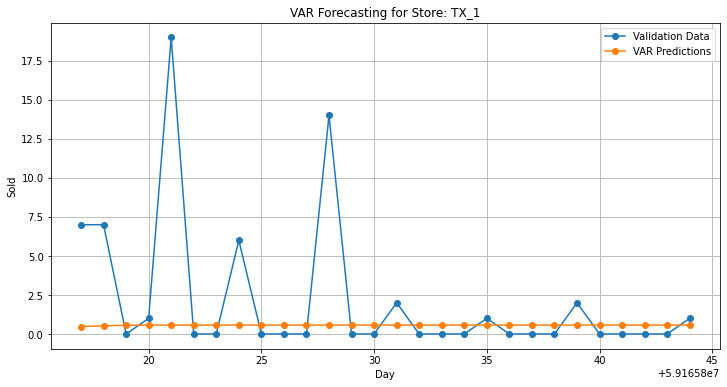

Root Mean Squared Error (RMSE) for store 5: 15.019719495559146


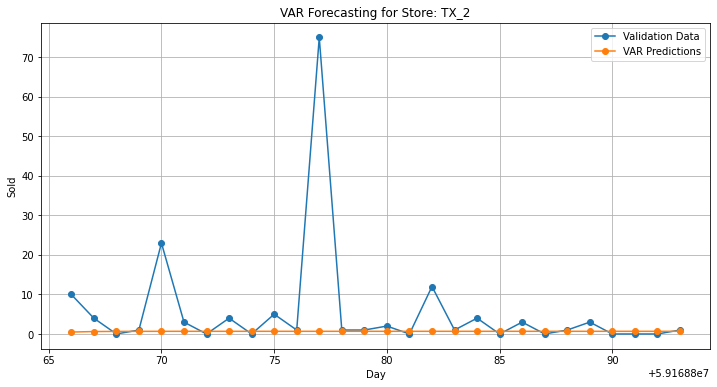

KeyboardInterrupt: 

In [81]:
# from statsmodels.tsa.vector_ar.var_model import VAR
# from sklearn.metrics import mean_squared_error
# import joblib

# # Define the lag order for the VAR model
# lag_order = 2

# for store in stores:
#     df_temp = df[df['store_id'] == store]
#     model_filename = 'var_model' + str(d_store_id[store]) + '.pkl'

#     # Get the last 200 days of data for training
#     train_data = df_temp[df_temp['d'] >= (1914)][['sold', 'sold_lag_1', 'sold_lag_6', 'sold_lag_7',
#                                                         'sold_lag_8', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28',
#                                                         'sold_lag_35']]

#     model = VAR(train_data)
#     model_fit = model.fit(lag_order)

#     valid_preds = model_fit.forecast(train_data.values[-lag_order:], steps=28)

#     valid_preds = valid_preds[:, 0]

#     validation_data = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)]['sold'].values[-28:]

#     rmse = np.sqrt(mean_squared_error(validation_data, valid_preds))
#     print(f'Root Mean Squared Error (RMSE) for store {store}: {rmse}')

#     validation_index = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)].index[-28:] 

#     plt.figure(figsize=(12, 6))
#     plt.plot(validation_index, validation_data, label='Validation Data', marker='o')
#     plt.plot(validation_index, valid_preds, label='VAR Predictions', marker='o')

#     plt.title('VAR Forecasting for Store: {}'.format(d_store_id[store]))
#     plt.xlabel('Day')
#     plt.ylabel('Sold')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     joblib.dump(model_fit, model_filename)

#     del model_fit, df_temp
#     gc.collect()


In [83]:
columns_to_fill_zero = ['sold', 'sold_lag_1', 'sold_lag_6', 'sold_lag_7',
                        'sold_lag_8', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28',
                        'sold_lag_35']

df[columns_to_fill_zero] = df[columns_to_fill_zero].fillna(0)


Root Mean Squared Error (RMSE) for store 0: 2.528253802840324


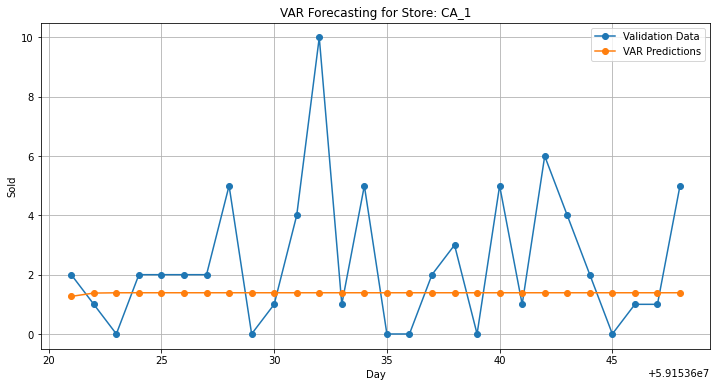

KeyboardInterrupt: 

In [89]:
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error

lag_order = 1

for store in stores:
    df_temp = df[df['store_id'] == store]
    model_filename = f'var_model_{d_store_id[store]}.pkl'

    train_data = df_temp[df_temp['d'] >= (1914 - 900)][['sold', 'sold_lag_1']]

    model = VAR(train_data)
    model_fit = model.fit(lag_order)

    valid_preds = model_fit.forecast(train_data.values[-lag_order:], steps=28)

    valid_preds = valid_preds[:, 0]

    validation_data = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)]['sold'].values[-28:]

    rmse = np.sqrt(mean_squared_error(validation_data, valid_preds))

    print(f'Root Mean Squared Error (RMSE) for store {store}: {rmse}')

    validation_index = df_temp[(df_temp['d'] >= 1914) & (df_temp['d'] < 1942)].index[-28:]  

    plt.figure(figsize=(12, 6))
    plt.plot(validation_index, validation_data, label='Validation Data', marker='o')
    plt.plot(validation_index, valid_preds, label='VAR Predictions', marker='o')

    plt.title(f'VAR Forecasting for Store: {d_store_id[store]}')
    plt.xlabel('Day')
    plt.ylabel('Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

    joblib.dump(model_fit, model_filename)

    del model_fit, df_temp
    gc.collect()


In [101]:
# import xgboost as xgb
# import joblib
# import gc

# # Define XGBoost parameters
# xgb_params = {
#     'objective': 'reg:squarederror',
#     'n_estimators': 700,
#     'learning_rate': 0.1,
#     'subsample': 0.8,
#     'colasample_bytree': 0.8,
#     'max_depth': 8,
#     'min_child_weight': 300,
#     'eval_metric': 'rmse',
# }

# for store in stores:
#     df_temp = df[df['store_id'] == store]
#     model_filename = 'xgboost_model' + str(d_store_id[store]) + '.pkl'

#     #Split the data
#     X_train, y_train = df_temp[df_temp['d']<1914].drop('sold',axis=1), df_temp[df_temp['d']<1914]['sold']
#     X_valid, y_valid = df_temp[(df_temp['d']>=1914) & (df_temp['d']<1942)].drop('sold',axis=1), df_temp[(df_temp['d']>=1914) & (df_temp['d']<1942)]['sold']
#     X_test = df_temp[df_temp['d']>=1942].drop('sold',axis=1)

#     print('*****Prediction for Store: {}*****'.format(d_store_id[store]))
#     model = xgb.XGBRegressor(**xgb_params, tree_method='gpu_hist',  gpu_id=0)
#     model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
#               early_stopping_rounds=20, verbose=20)

#     valid_preds[X_valid.index] = model.predict(X_valid)
#     eval_preds[X_test.index] = model.predict(X_test)

#     joblib.dump(model, model_filename)

#     del model, X_train, y_train, X_valid, y_valid, X_test, df_temp
#     gc.collect()


*****Prediction for Store: CA_1*****
[23:43:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colasample_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:3.83232	validation_1-rmse:3.47141
[20]	validation_0-rmse:2.05274	validation_1-rmse:1.84210
[40]	validation_0-rmse:1.99080	validation_1-rmse:1.80246
[60]	validation_0-rmse:1.97939	validation_1-rmse:1.79903
[80]	validation_0-rmse:1.97000	validation_1-rmse:1.79719
[100]	validation_0-rmse:1.96029	validation_1-rmse:1.79585
[120]	validation_0-rmse:1.95326	validation_1-rmse:1.79486
[140]	validation_0-rmse:1.94818	validation_1-rmse:1.79468
[157]	validation_0-rmse:1.94483	validation_1-rmse:1.79458
*****Prediction for S

In [96]:
# import os

# feature_importance_df = pd.DataFrame()
# features = [f for f in df.columns if f != 'sold']
# for filename in os.listdir('./'):
#     if 'model' in filename:
#         # load model
#         model = joblib.load(filename)
#         store_importance_df = pd.DataFrame()
#         store_importance_df["feature"] = features
#         store_importance_df["importance"] = model.feature_importances_
#         store_importance_df["store"] = filename[5:9]
#         feature_importance_df = pd.concat([feature_importance_df, store_importance_df], axis=0)

# def display_importances(feature_importance_df_):
#     cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:20].index
#     best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
#     plt.figure(figsize=(8, 10))
#     sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
#     plt.tight_layout()

# display_importances(feature_importance_df)

In [103]:
actual = False
if actual == False:
    validation = sales[['id']+['d_' + str(i) for i in range(1914,1942)]]
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation['id'] = validation['id'].astype('string')
    validation["id"] = validation["id"].apply(lambda x: x.replace("evaluation", "validation"))
else:
    valid['sold'] = valid_preds
    validation = valid[['id','d','sold']]
    validation = pd.pivot(validation, index='id', columns='d', values='sold').reset_index()
    validation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
    validation.id = validation.id.map(d_id).str.replace('evaluation','validation')

test['sold'] = eval_preds
evaluation = test[['id','d','sold']]
evaluation = pd.pivot(evaluation, index='id', columns='d', values='sold').reset_index()
evaluation.head()

d,id,1942,1943,1944,1945,1946,1947,1948,1949,1950,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969
0,0,0.198124,0.206485,0.215171,0.050658,0.042945,0.006561,-0.034555,0.021582,0.027837,...,0.057050,0.009999,-0.030631,0.008691,0.023060,0.035323,0.050030,0.055204,0.015531,-0.128335
1,1,0.509859,0.506745,0.488622,0.489723,0.392148,-0.026769,-0.006773,0.070596,0.091073,...,0.101421,0.006477,0.022930,-0.004642,0.093385,0.075483,0.075667,0.069284,-0.040049,-0.091409
2,2,1.129951,1.001355,0.891361,0.891361,0.564100,0.355238,0.015452,0.015452,0.015452,...,0.015452,0.015452,0.015452,0.015452,0.015452,0.015452,0.015452,0.015452,0.015452,0.015452
3,3,0.306509,0.284691,0.153636,0.007245,0.010666,-0.036484,-0.011593,0.004562,0.006220,...,0.002268,-0.042920,0.026469,-0.009817,0.046048,0.048174,0.039401,0.001469,-0.045681,0.015358
4,4,1.428599,0.763808,0.761389,0.520229,0.280553,0.289169,0.019068,0.024148,0.020833,...,0.010172,-0.029369,0.009549,0.017669,0.029006,-0.003095,0.013927,0.009417,-0.030877,-0.022773


In [104]:
evaluation.columns=['id'] + ['F' + str(i + 1) for i in range(28)]
evaluation.id = evaluation.id.map(d_id)

submit = pd.concat([validation,evaluation]).reset_index(drop=True)
submit.to_csv('submission.csv',index=False)

In [95]:
submit.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,2.0,0.0,3.0,5.0,0.0,0.0,...,2.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0
1,HOBBIES_1_002_CA_1_validation,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0
3,HOBBIES_1_004_CA_1_validation,0.0,0.0,1.0,2.0,4.0,1.0,6.0,4.0,0.0,...,1.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,2.0,6.0
4,HOBBIES_1_005_CA_1_validation,1.0,0.0,2.0,3.0,1.0,0.0,3.0,2.0,3.0,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0


In [96]:
submit.tail()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,HOUSEHOLD_2_516_TX_2_evaluation,0.190656,0.188284,0.170610,0.209707,0.214633,0.260260,0.257255,0.245857,0.188284,...,0.213495,0.237003,0.240846,0.170014,0.182421,0.116939,0.207943,0.207686,0.248332,0.229119
60976,HOUSEHOLD_2_516_TX_3_evaluation,0.136756,0.206483,0.184100,0.221139,0.173611,0.258528,0.243989,0.176512,0.206483,...,0.227931,0.249371,0.230886,0.142082,0.209286,0.183976,0.217985,0.169612,0.257688,0.237318
60977,HOUSEHOLD_2_516_WI_1_evaluation,0.056081,0.054881,0.094898,0.101719,0.149202,0.011899,0.152908,0.122045,0.054881,...,0.137344,0.027119,0.141640,0.054510,0.068946,0.066090,0.099998,0.137048,0.000293,0.082258
60978,HOUSEHOLD_2_516_WI_2_evaluation,0.042167,0.094401,0.073469,0.103872,0.123636,0.145378,0.140748,0.055544,0.094401,...,0.176583,0.132525,0.155045,0.116142,0.095223,0.050872,0.113314,0.136239,0.126528,0.176970
60979,HOUSEHOLD_2_516_WI_3_evaluation,0.088442,0.083386,0.069105,0.076706,0.113507,0.134905,0.145271,0.116583,0.083386,...,0.128185,0.133285,0.173599,0.092543,0.112319,0.082205,0.102183,0.118768,0.126484,0.179519


In [ ]:
! kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "after adding rooling mean + new features"

In [ ]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,14370,1437,3,1,0,0,1,0,11101,2,...,1,2011,19,2,3,1,0,0,0,6.225271
1,14380,1438,3,1,0,0,1,0,11101,2,...,1,2011,19,2,3,1,0,0,0,6.225271
2,14390,1439,3,1,0,0,1,0,11101,2,...,1,2011,19,2,3,1,0,0,0,6.225271
3,14400,1440,3,1,0,0,1,0,11101,2,...,1,2011,19,2,3,1,0,0,0,6.225271
4,14410,1441,3,1,0,0,1,0,11101,2,...,1,2011,19,2,3,1,0,0,0,6.225271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,11621,3,...,6,2016,16,4,2,0,0,0,0,2.980469
60034806,14339,1433,2,0,9,2,1969,0,11621,3,...,6,2016,16,4,2,0,0,0,0,2.480469
60034807,14349,1434,2,0,9,2,1969,0,11621,3,...,6,2016,16,4,2,0,0,0,0,3.980469
60034808,14359,1435,2,0,9,2,1969,0,11621,3,...,6,2016,16,4,2,0,0,0,0,1.280273
